# Udacity Capstone Project
## Starbucks Promotional Offers
### April 2023

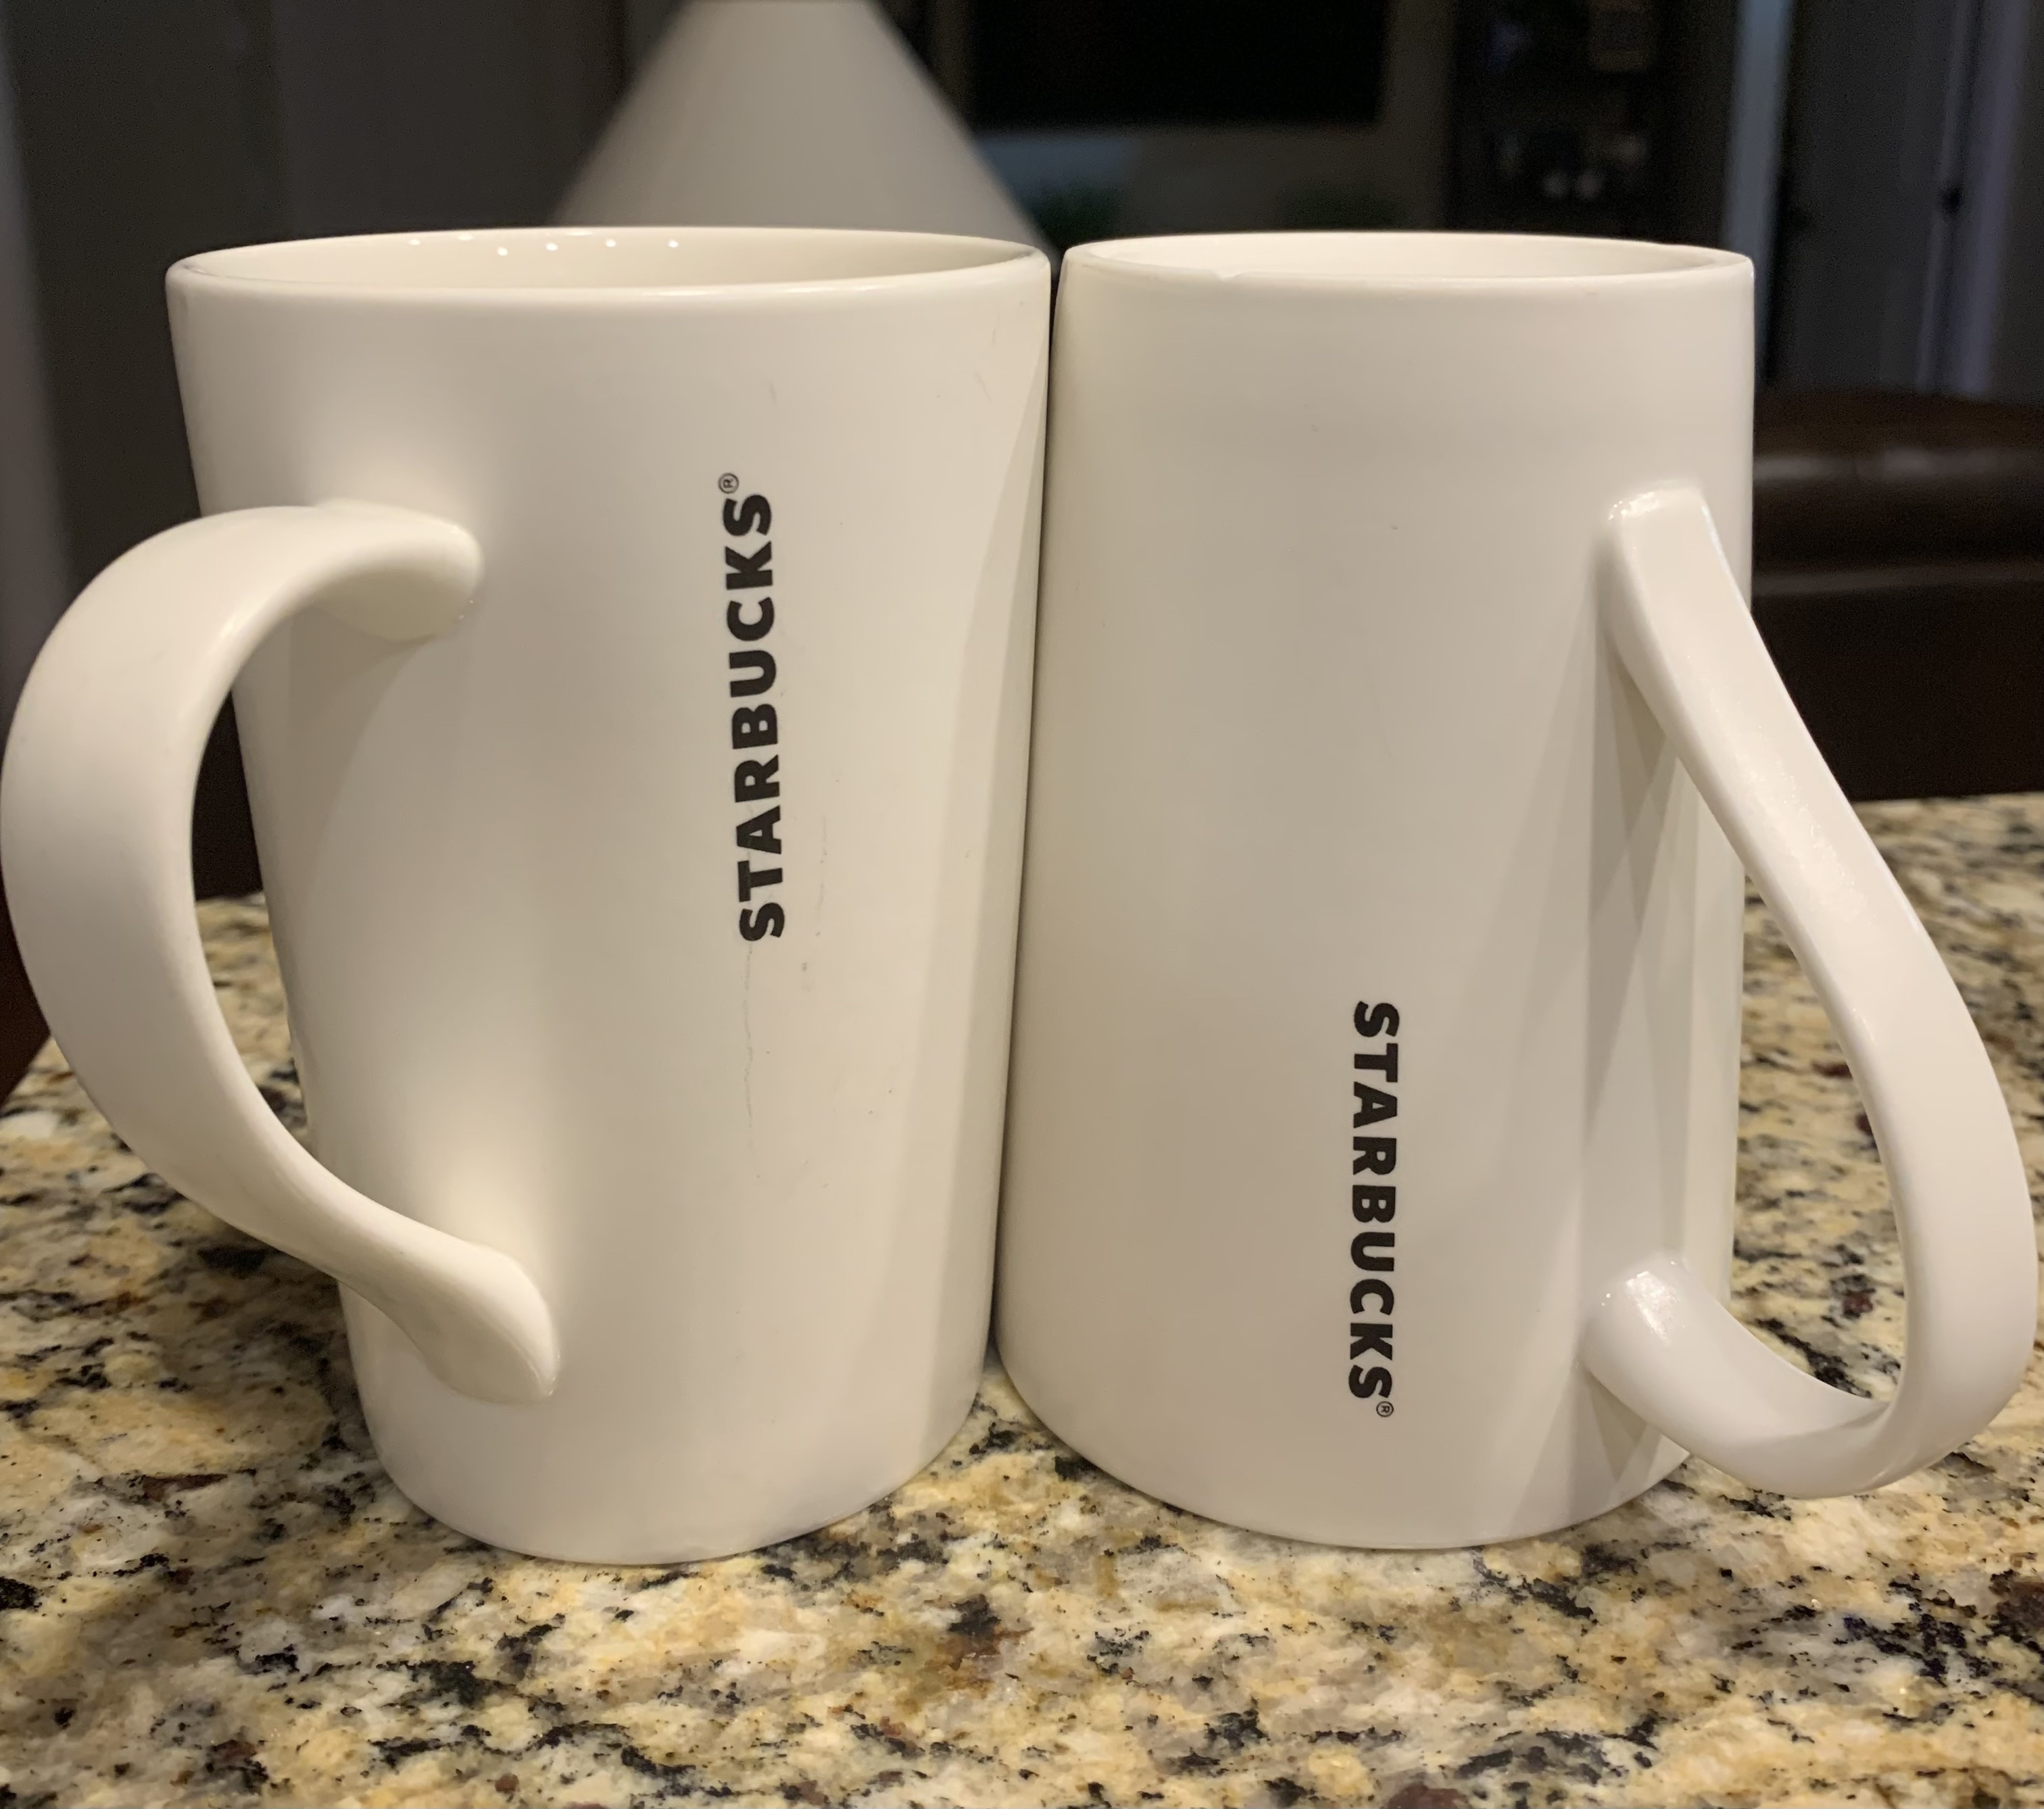

# Data Sets
The data for this project are contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed

## Schema details
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - monetary reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle_data import clean_portfolio, clean_profile, clean_transcript, merge_data, age_bins, income_bins, extract_offer_id, extract_amount
import recommendations as r
from recommendations import Recommender
from recommender_functions import create_ranked_offers, popular_recommendations, create_user_item_matrix, find_similar_users, get_offer_ids, get_user_offers, user_user_recs, compute_correlation, compute_euclidean_dist, compute_manhattan_dist
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from math import sqrt
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### portfolio.json

In [3]:
# look at first few rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# shape of portfolio data
print('Number of portfolio data rows: {}'.format(portfolio.shape[0]))
print('Number of portfolio data columns: {}'.format(portfolio.shape[1]))

Number of portfolio data rows: 10
Number of portfolio data columns: 6


In [5]:
# column information
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# any missing values
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
# summary stats
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0


In [8]:
# how many unique offer ids
print('Unique offer ids: {}'.format(portfolio.id.nunique()))

Unique offer ids: 10


In [9]:
# distribution of offer ids
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [10]:
# distribution of offer durations
portfolio.duration.value_counts()

7     4
5     2
10    2
4     1
3     1
Name: duration, dtype: int64

### profile.json

In [11]:
# look at first few rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# shape of profile data
print('Number of profile data rows: {}'.format(profile.shape[0]))
print('Number of profile data columns: {}'.format(profile.shape[1]))

Number of profile data rows: 17000
Number of profile data columns: 5


In [13]:
# column information
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
# any missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
# summary stats
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [16]:
# 118 seems a bit high for max age
profile.loc[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### transcript.json

In [18]:
# look at first few rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
# shape of transcript data
print('Number of transcript data rows: {}'.format(transcript.shape[0]))
print('Number of transcript data columns: {}'.format(transcript.shape[1]))

Number of transcript data rows: 306534
Number of transcript data columns: 4


In [20]:
# column information
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# any missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [22]:
# what are the unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [23]:
# what are the event counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# what does a transaction value look like
transcript.query('event == "transaction"')['value'].iloc[0]

{'amount': 0.8300000000000001}

In [25]:
# what does a offer received value look like
transcript.query('event == "offer received"')['value'].iloc[0]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [26]:
# what does a offer viewed value look like
transcript.query('event == "offer viewed"')['value'].iloc[0]

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

In [27]:
# what does a offer completed value look like
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

### Data Observations
#### portfolio.json
- channels can be one-hot encoded
- offer_type can be one-hot encoded
- id column is offer_id
- there are no missing values

#### profile.json 
- id in this data set is a customer id
- gender and income each have 2175 missing values. 
- maximum age is 118, which appears out of line. 
- age = 118 is in the same 2175 records with missing gender and income.
- became_member_on is a data field, but represented as integer

#### transcript.json 
- time column represents hours since start of test, but is integer format
- people column is equivalent to customer id in profile dataset

## Data Cleaning

#### portfolio dataframe
- rename "id" column to "offer_id"
- rename "duration" column to "days_open"
- rename "difficulty" column to "min_spend"
- one-hot encode "channels" column
- one-hot encode "offer_type" column
- drop "channels" and "offer_type" columns after one-hot encoding

In [28]:
# call clean_portfolio function to clean the portfolio dataset
portfolio_clean = clean_portfolio()
portfolio_clean

,offer_id,reward,min_spend,days_open,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0


#### profile dataframe
- rename "id" column to "customer_id"
- remove the 2175 rows where "gender" and "income" have missing values and "age" equals 118
- one-hot encode 'gender' column
- convert "became_member_on" to datetime and label "membership_start"
- create "membership_year" from "membership_start"
- reorder columns

In [29]:
# call clean_profile to clean profile data
profile_clean = clean_profile()
profile_clean.head()

,customer_id,age,income,female,male,membership_start,membership_year
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,2017-07-15,2017
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,2017-05-09,2017
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,2018-04-26,2018
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,2018-02-09,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,2017-11-11,2017


#### transcript dataframe
- rename 'person' column to 'customer_id'
- one-hot encode 'event' column
- split transcript dataframe into transaction and offers dataframes
- extract 'offer_id' from 'value' column
- extract 'transaction' from 'value' column
- drop unneeded columns

In [30]:
# call clean_transcript to clean transcript data
transcript_clean = clean_transcript()

In [31]:
transcript_clean.head(2)

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,NaN,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,1,0,NaN,0


### Merge dataframes and write out resultant dataframe to csv

In [32]:
# call merge_data to merge cleaned data sets and write out offers and transactions csv files 
merge_data(portfolio_clean, profile_clean, transcript_clean)

In [33]:
# read in cleaned data and display first couple of rows
combined_df = pd.read_csv('data/starbucks_combined_data.csv')
combined_df.head(2)

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,web,bogo,discount,informational,age,income,female,male,membership_start,membership_year
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,1.0,0.0,0.0,75.0,100000.0,1.0,0.0,2017-05-09,2017.0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration and Analysis

In [34]:
# shape of combined_df
print('Number of combined_df data rows: {}'.format(combined_df.shape[0]))
print('Number of combined_df data columns: {}'.format(combined_df.shape[1]))

Number of combined_df data rows: 306534
Number of combined_df data columns: 23


For comparison, it may be useful to have 'age' and 'income' ranges.

In [35]:
# 'age' summary stats - offers dataset
combined_df['age'].describe().T

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [36]:
# 'income' summary stats - offers dataset
combined_df['income'].describe().T

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

In [37]:
# create age bins in offers dataset
combined_df = age_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,0.0,2017-05-09,2017.0,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0.0,1.0,2018-04-26,2018.0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [38]:
# create income bins in offers dataset
combined_df = income_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,30-44,45-59,60-74,75-89,90-101,30k-49k,50k-69k,70k-89k,90k-109k,110k-120k
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,0,0,0,1,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,0,0,0,0,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0,0,1,0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,0,0,0,0,0,0,0,0,0,0


### Look at some simple frequency distributions

In [39]:
# create age and income dictionaries
age_cols = ['18-29', '30-44', '45-59', '60-74', '75-89', '90-101']
income_cols = ['30k-49k', '50k-69k', '70k-89k', '90k-109k', '110k-120k']

In [40]:
# age distribution in offers
age_dist = combined_df[combined_df['offer_completed'] == 1][age_cols].sum()
age_dist

18-29      2577
30-44      5126
45-59     11014
60-74      9351
75-89      3618
90-101      629
dtype: int64

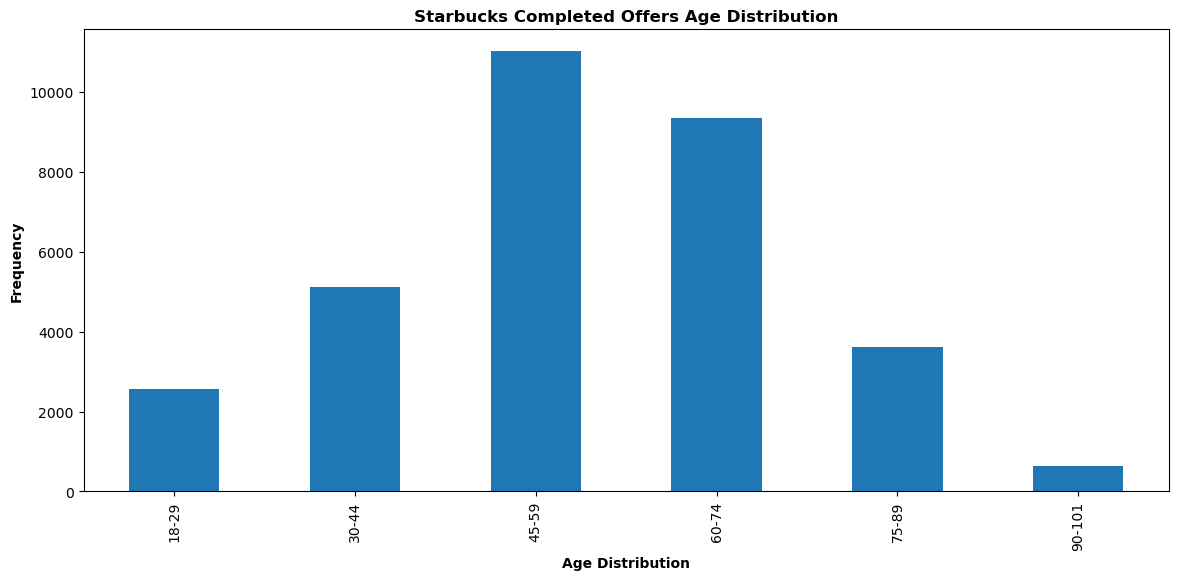

In [41]:
# plot offers age distribution
plt.figure(figsize = (14, 6))
age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Age Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 45-years to 74-years age group.

In [42]:
# income distribution in offers
income_dist = combined_df[combined_df['offer_completed'] == 1][income_cols].sum()
income_dist

30k-49k       5943
50k-69k      10521
70k-89k       9535
90k-109k      4865
110k-120k     1460
dtype: int64

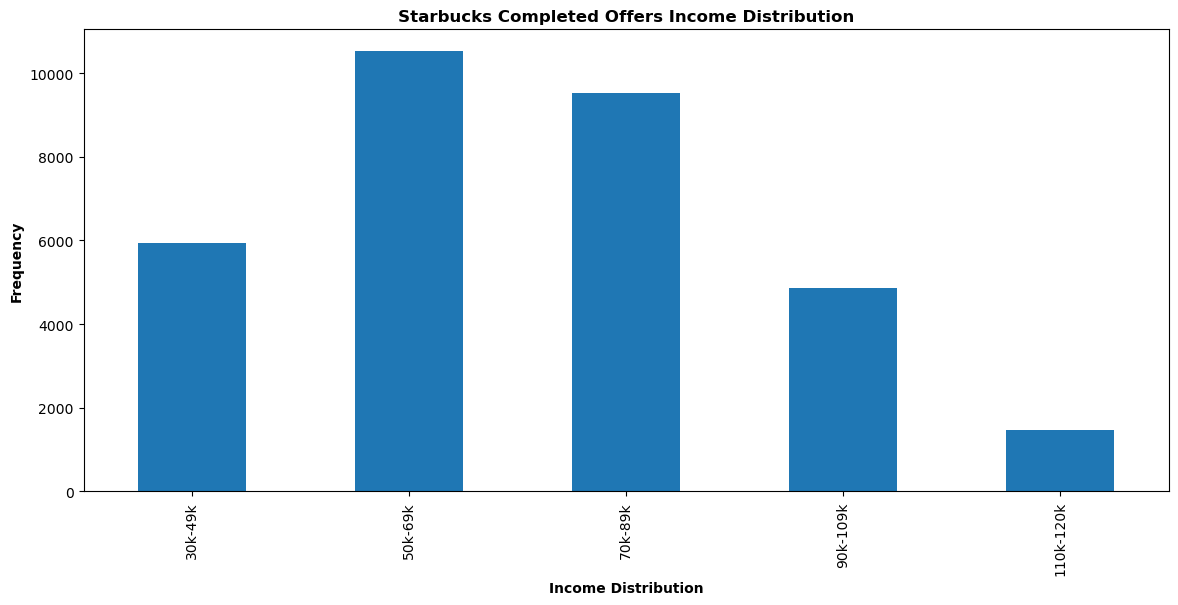

In [43]:
# plot offers income distribution
plt.figure(figsize = (14, 6))
income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Income Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 50,000 - 89,000 income range.

In [44]:
# offer type distribution in offers
offer_type_cols = ['bogo', 'discount']
offer_type_dist = combined_df[combined_df['offer_completed'] == 1][offer_type_cols].sum()
offer_type_dist

bogo        15669.0
discount    17910.0
dtype: float64

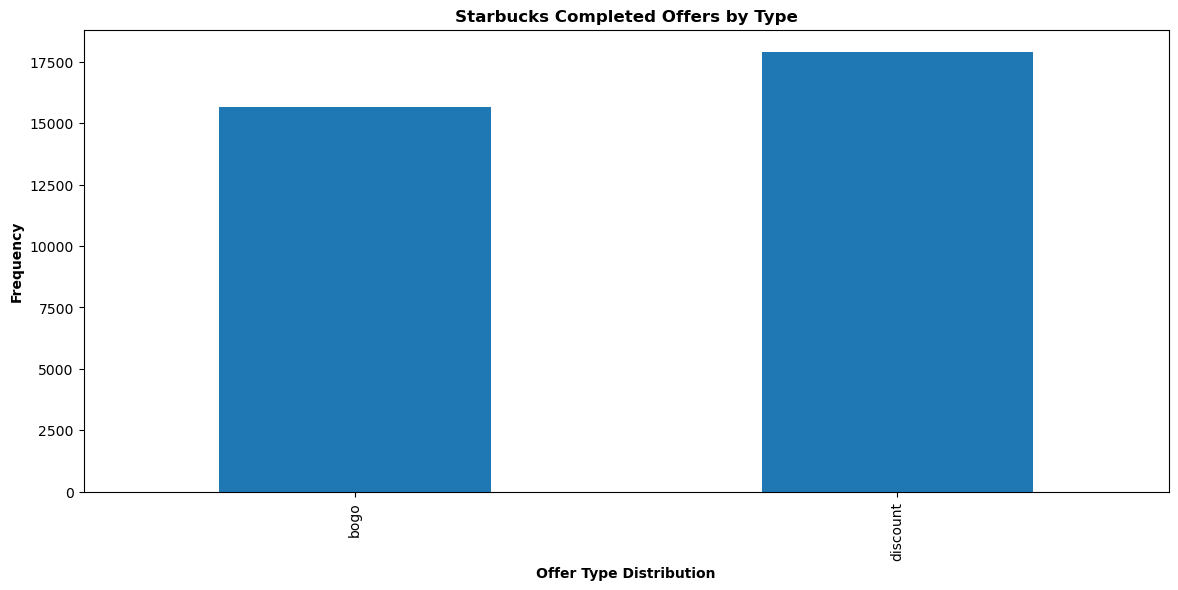

In [45]:
# plot offer type distribution
plt.figure(figsize = (14, 6))
offer_type_dist.plot(kind = 'bar')
plt.xlabel('Offer Type Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Type', weight = 'bold');

> Discount offers are slightly more prevelant than bogo.

In [46]:
channels_cols = ['email', 'mobile', 'social', 'web']
offer_channels_dist = combined_df[combined_df['offer_completed'] == 1][channels_cols].sum()
offer_channels_dist

email     33579.0
mobile    30159.0
social    21788.0
web       29891.0
dtype: float64

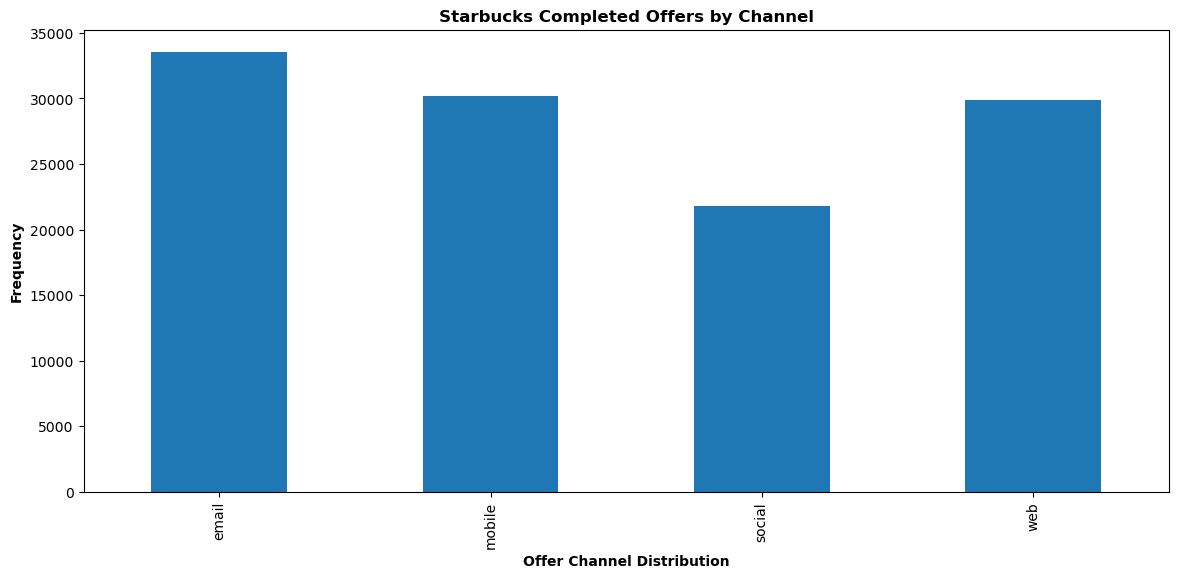

In [47]:
# plot offer channel distribution
plt.figure(figsize = (14, 6))
offer_channels_dist.plot(kind = 'bar')
plt.xlabel('Offer Channel Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Channel', weight = 'bold');

> Email channel frequency is slightly higher than mobile and web.

In [48]:
# offer type distribution in offers
gender_cols = ['male', 'female']
gender_dist = combined_df[combined_df['offer_completed'] == 1][gender_cols].sum()
gender_dist

male      16466.0
female    15477.0
dtype: float64

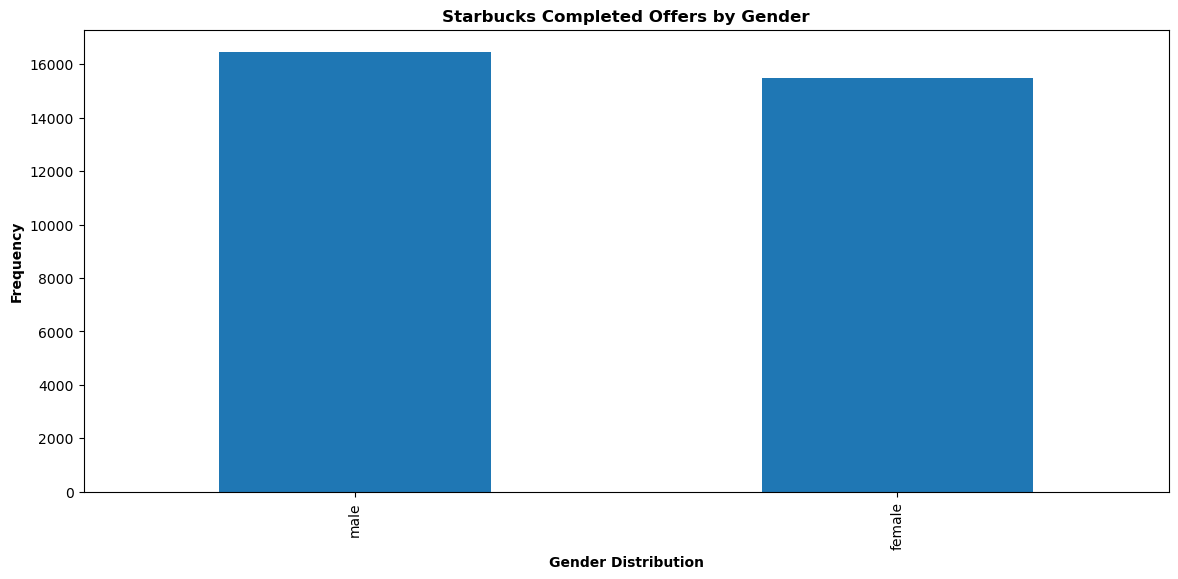

In [49]:
# plot gender distribution
plt.figure(figsize = (14, 6))
gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Gender', weight = 'bold');

> Slightly higher number of completed offers for male customers.

In [50]:
# age distribution of transaction data
t_age_dist = combined_df[combined_df['amount'] > 0][age_cols].sum()
t_age_dist

18-29     15528
30-44     24294
45-59     37873
60-74     31511
75-89     12022
90-101     2030
dtype: int64

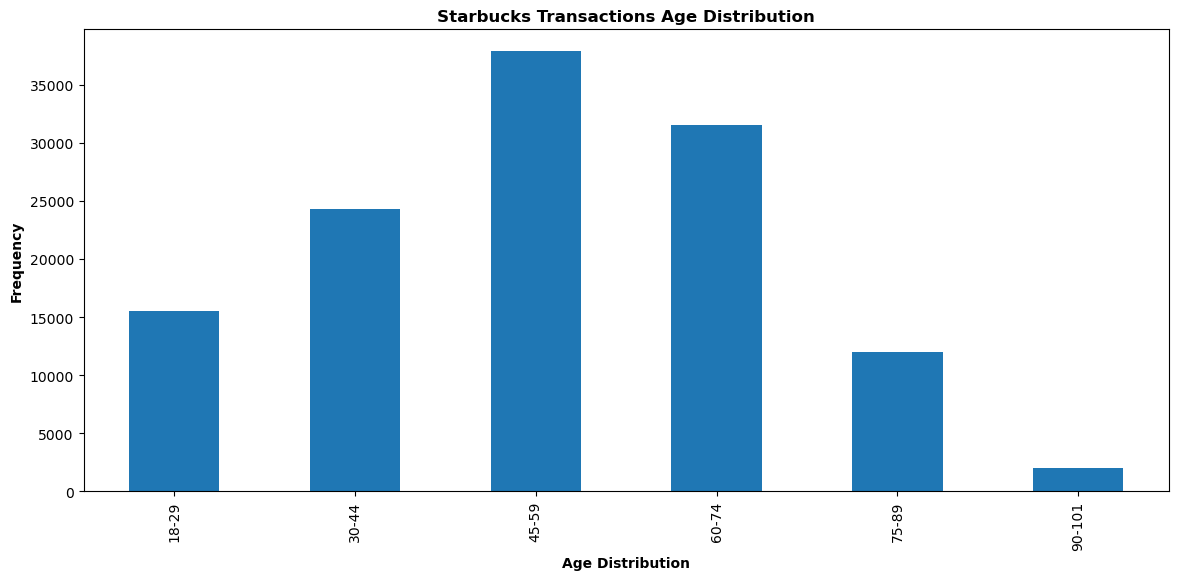

In [51]:
# plot transaction age distribution
plt.figure(figsize = (14, 6))
t_age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Age Distribution', weight = 'bold');

> Similar to the completed offers data, the bulk of transaction data is in the 45-years to 74-years age groups.

In [52]:
# income distribution of transaction data
t_income_dist = combined_df[combined_df['amount'] > 0][income_cols].sum()
t_income_dist

30k-49k      37075
50k-69k      45035
70k-89k      26610
90k-109k     11178
110k-120k     3185
dtype: int64

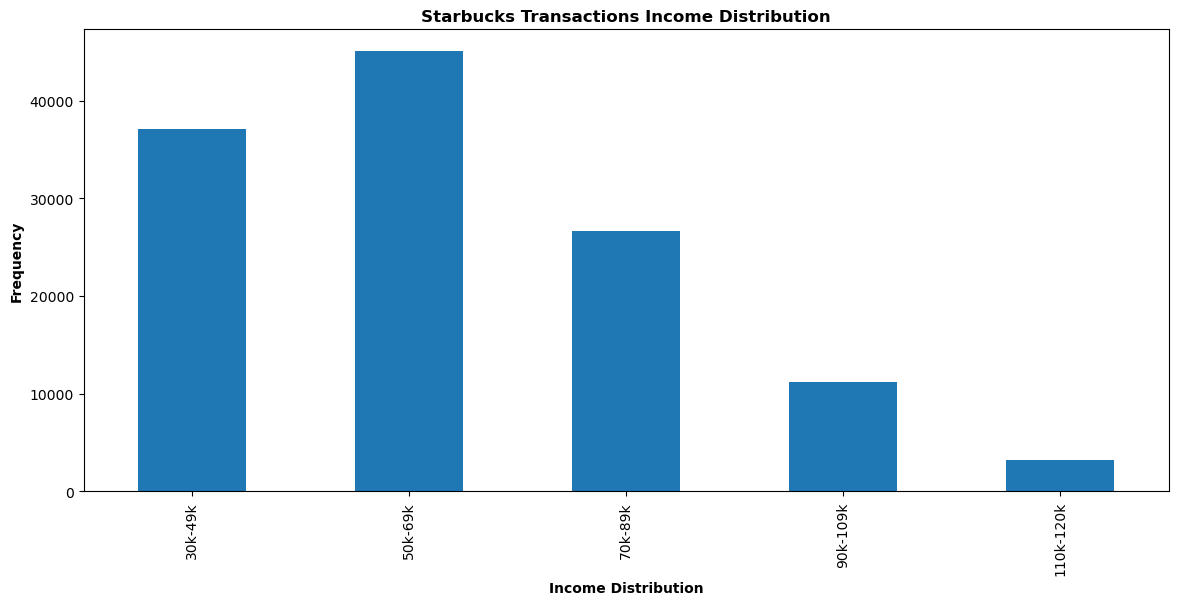

In [53]:
# plot transaction income distribution
plt.figure(figsize = (14, 6))
t_income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Income Distribution', weight = 'bold');

> Income distribution is shifted lower with the transaction data, with the bulk in the 30,000 to 69,000 range.

In [54]:
# income distribution of transaction data
t_gender_dist = combined_df[combined_df['amount'] > 0][gender_cols].sum()
t_gender_dist

male      72794.0
female    49382.0
dtype: float64

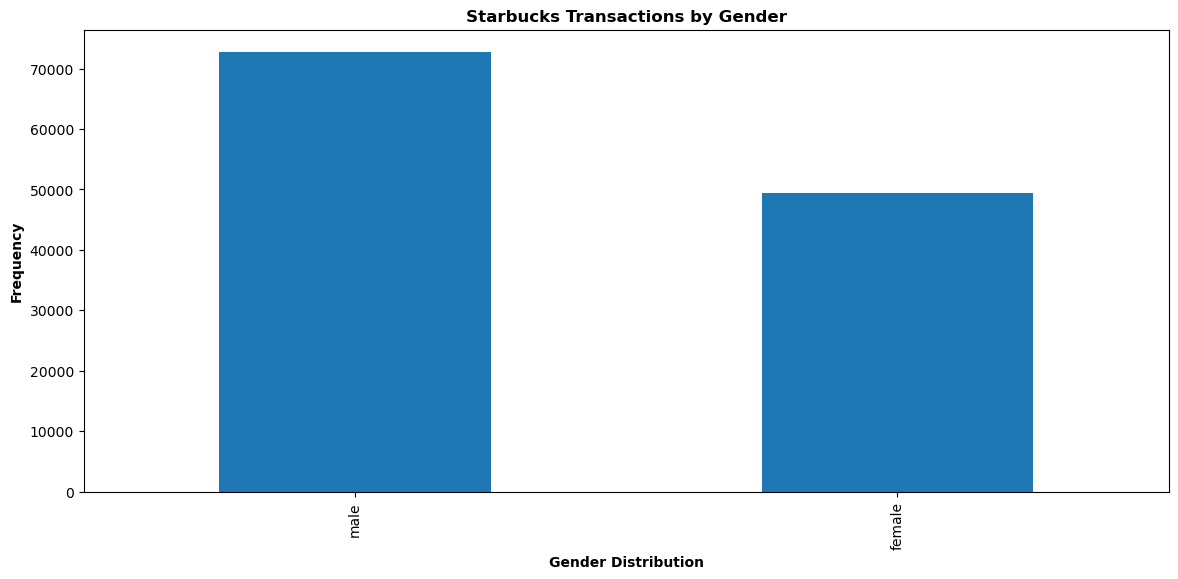

In [55]:
# plot gender distribution
plt.figure(figsize = (14, 6))
t_gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions by Gender', weight = 'bold');

> Transactions for males are significantly higher.

In [56]:
# which customers are the big spenders
top_amounts = combined_df.groupby('customer_id')['amount'].sum().nlargest(10)
top_amounts

customer_id
4029     1608.69
16081    1365.66
11703    1327.74
6519     1321.42
7673     1319.97
5494     1292.86
11615    1258.19
14016    1251.99
9913     1232.40
6640     1211.76
Name: amount, dtype: float64

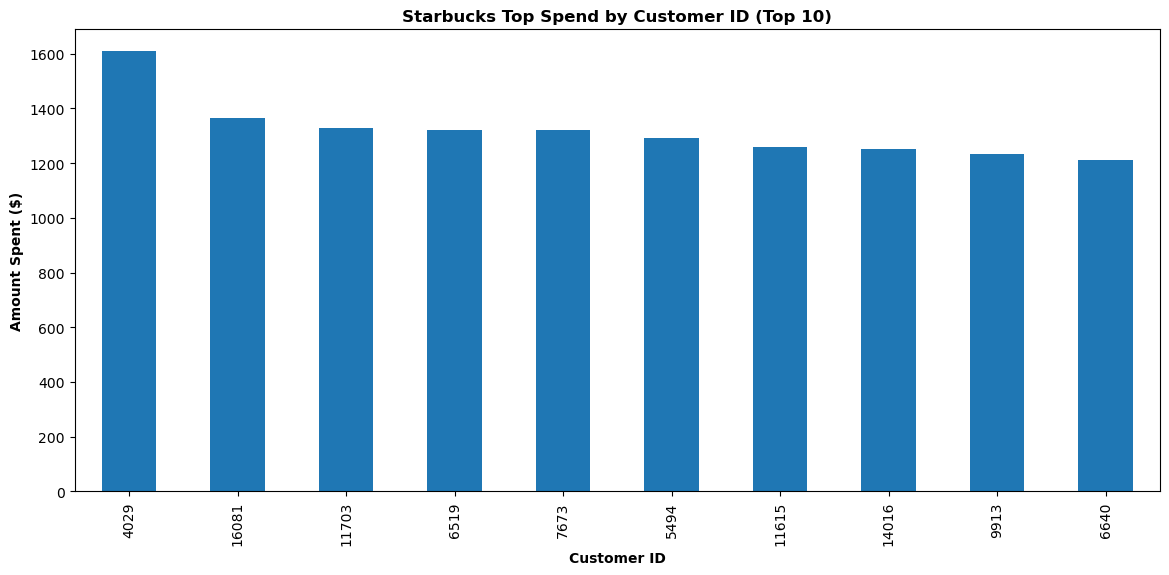

In [57]:
# plot gender distribution
plt.figure(figsize = (14, 6))
top_amounts.plot(kind = 'bar')
plt.xlabel('Customer ID', weight = 'bold')
plt.ylabel('Amount Spent ($)', weight = 'bold')
plt.title('Starbucks Top Spend by Customer ID (Top 10)', weight = 'bold');

> Customer ID 4029 has spent more than 200 dollars above the nearest customer ID.

### Most Popular Recommendation
1. Rank offers based on ratio of offers_viewed to offers_received
2. Determine the most popular offers_ids based on rank

In [58]:
# offers ranked by viewed_ratio (offers_viewed / offers_received)
ranked_viewed = create_ranked_offers(combined_df)
ranked_viewed

,offer_id,offer_received,offer_viewed,viewed_ratio
9,9,7597,7327,0.964460
4,4,7593,7298,0.961148
1,1,7646,7337,0.959587
8,8,7571,7264,0.959451
5,5,7618,6687,0.877789
7,7,7658,6716,0.876991
3,3,7617,4144,0.544046
6,6,7677,4171,0.543311
2,2,7632,4118,0.539570
0,0,7668,2663,0.347287


In [59]:
# get the 5 most viewed offer_id's
customer_id = 13234
num_offers = 5
recs = popular_recommendations(customer_id, num_offers, ranked_viewed)
recs

The top 5 offer recommendations for customer 13234:


[9, 4, 1, 8, 5]

In [60]:
# test function handles invalid input
customer_id = 13234
num_offers = 25
recs_err = popular_recommendations(customer_id, num_offers, ranked_viewed)
recs_err

Please enter an offer_id value less than or equal to 10.


### User-user collaborative filtering
1. Create user item matrix
    - Each **customer** should only appear in each row once.
    - Each **offer** should only show up in one column.
    - If a customer has viewed an offer, then place a 1 where the customer-row meets for that offer-column. It does not matter how many times a customer has interacted with the offer, all entries where a customer has interacted with an offer should be a 1.
    - If a customer has not interacted with an offer, then place a zero where the customer-row meets for that offer-column.
2. Call *find_similar_users* to find customers similar to the input customer_id
    - take a customer_id and provide an ordered list of the most similar customers to that customer (from most similar to least similar). The returned result should not contain the provided customer_id, as we know that each customer is similar to him/herself.

In [61]:
# create the user item matrix
user_item_matrix = create_user_item_matrix(combined_df)
user_item_matrix.head()

offer_id,0,1,2,3,4,5,6,7,8,9,10
customer_id,,,,,,,,,,,
0,0,0,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,1,0,1,1,0,0,0,1
3,0,0,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,1,0,1


In [62]:
# shape of the user item matrix
print('User item matrix rows: ', user_item_matrix.shape[0])
print('User item matrix columns: ', user_item_matrix.shape[1])

User item matrix rows:  17000
User item matrix columns:  11


#### Find simlar users

In [63]:
# Call find_similar_users, passing in customer_id and user item matrix
print("The 10 most similar users to user 13234 are: {}".format(find_similar_users(13234, user_item_matrix)[:10]))
print("The 5 most similar users to user 1759 are: {}".format(find_similar_users(1759, user_item_matrix)[:5]))
print("The 3 most similar users to user 203 are: {}".format(find_similar_users(203, user_item_matrix)[:3]))

The 10 most similar users to user 13234 are: [5439, 13757, 3133, 10578, 3156, 15533, 15511, 8177, 1055, 11821]
The 5 most similar users to user 1759 are: [10807, 5323, 647, 6571, 4228]
The 3 most similar users to user 203 are: [5132, 11254, 487]


### Collaborative Filtering
1. Create user item matrix
    - same as above. Not really necessary, but creating fresh version for this section
2. Get a list of offer_ids
    - call *get_offer_ids* function
3. Get a list of offer_ids for a given customer
    - call *get_user_offers* function
4. Make recommendations based on closeness to a customer
    - call *user_user_recs* function
5. Compute correlation between two customers
6. Compute Euclidean distance between two customers
7. Compute Manhattan distance between two customers

In [64]:
# create the user item matrix for user-user collaborative filtering
customer_by_offerid = create_user_item_matrix(combined_df)
customer_by_offerid.head()

offer_id,0,1,2,3,4,5,6,7,8,9,10
customer_id,,,,,,,,,,,
0,0,0,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,1,0,1,1,0,0,0,1
3,0,0,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,1,0,1


#### Recommend offers

In [65]:
print('The 5 recommended offers for user 13234: {}'.format(get_offer_ids(user_user_recs(13234, customer_by_offerid, 5), combined_df)))
print('The 5 recommended offers for user 1759: {}'.format(get_offer_ids(user_user_recs(1759, customer_by_offerid, 5), combined_df)))
print('The 5 recommended offers for user 203: {}'.format(get_offer_ids(user_user_recs(203, customer_by_offerid, 5), combined_df)))

The 5 recommended offers for user 13234: ['0' '2' '3' '4' '6']
The 5 recommended offers for user 1759: ['0' '2' '3' '4' '5']
The 5 recommended offers for user 203: ['0' '1' '2' '4' '6']


#### Compute the correlation between two customers based on offers

In [66]:
# compute correlation between two customers
print('The correlation between customers 1759 and 13234 is: {}'.format(compute_correlation(customer_by_offerid, 1759, 13234)))

The correlation between customers 1759 and 13234 is: -0.2666666666666667


### Euclidean Distance

Euclidean distance can also just be considered as straight-line distance between two vectors.

For two vectors **x** and **y**, we can compute this as:

$$ EUC(\textbf{x}, \textbf{y}) = \sqrt{\sum\limits_{i=1}^{n}(x_i - y_i)^2}$$

In [67]:
# compute Euclidean distance between two customers
print('The Euclidean distance between customers 1759 and 13234 is: {}'.format(compute_euclidean_dist(customer_by_offerid, 1759, 13234)))

The Euclidean distance between customers 1759 and 13234 is: 2.6457513110645907


### Manhattan Distance

Different from euclidean distance, Manhattan distance is a 'manhattan block' distance from one vector to another.  Therefore, you can imagine this distance as a way to compute the distance between two points when you are not able to go through buildings.

Specifically, this distance is computed as:

$$ MANHATTAN(\textbf{x}, \textbf{y}) = \sqrt{\sum\limits_{i=1}^{n}|x_i - y_i|}$$

In [68]:
# compute Manhattan distance between two customers
print('The Manhattan distance between customers 1759 and 13234 is: {}'.format(compute_manhattan_dist(customer_by_offerid, 1759, 13234)))

The Manhattan distance between customers 1759 and 13234 is: 7


### Matrix Factorization

In [69]:
# initialize Recommender class for FunkSVD model
rec = Recommender()

In [70]:
# split data into train and test datasets
train, test = train_test_split(combined_df, test_size = 0.25)

#### Fit FunkSVD against training dataset four times, varying latent features by 5 starting at 5.

In [71]:
# fit FunkSVD on training dataframe with latent features = 5
train_user_mat5, train_offer_mat5, train_mse5 = rec.fit(train, latent_features=5)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.053159
16 		 0.025294
31 		 0.024398
46 		 0.023900
61 		 0.023431
76 		 0.022972
91 		 0.022521


In [72]:
# fit FunkSVD on training dataframe with latent features = 10
train_user_mat10, train_offer_mat10, train_mse10 = rec.fit(train, latent_features=10)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.143254
16 		 0.013958
31 		 0.012856
46 		 0.012668
61 		 0.012532
76 		 0.012400
91 		 0.012270


In [73]:
# fit FunkSVD on training dataframe with latent features = 15
train_user_mat15, train_offer_mat15, train_mse15 = rec.fit(train, latent_features=15)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.406437
16 		 0.010534
31 		 0.008817
46 		 0.008663
61 		 0.008596
76 		 0.008534
91 		 0.008472


In [74]:
# fit FunkSVD on training dataframe with latent features = 20
train_user_mat20, train_offer_mat20, train_mse20 = rec.fit(train, latent_features=20)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.464329
16 		 0.008654
31 		 0.006606
46 		 0.006458
61 		 0.006416
76 		 0.006380
91 		 0.006345


#### Plot mean squared errors (MSE) of the 4 FunkSVD executions against training data.

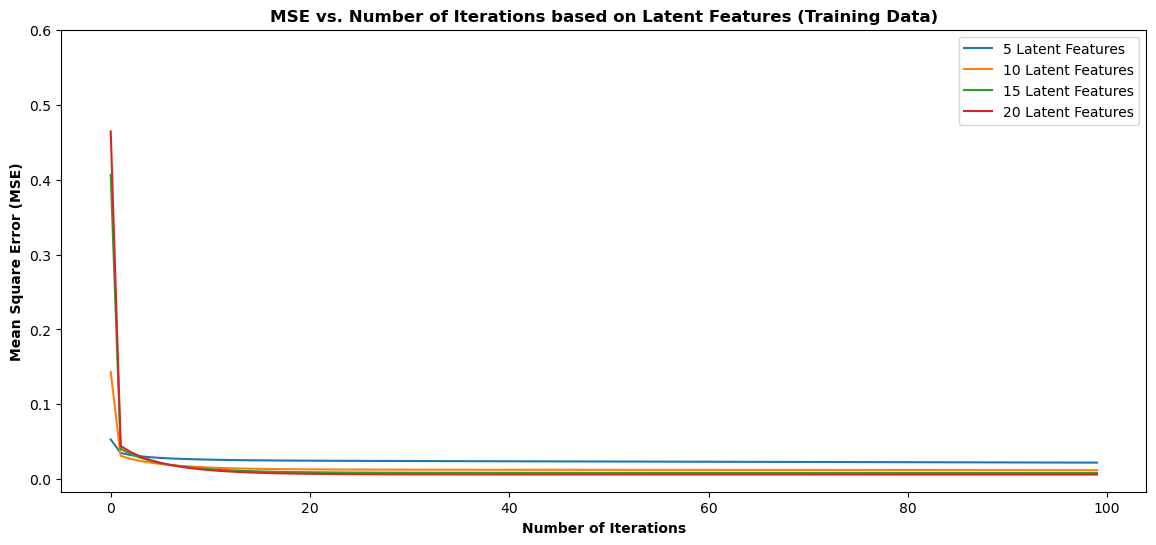

In [77]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))

plt.plot(range(iters), train_mse5, label = '5 Latent Features')
plt.plot(range(iters), train_mse10, label = '10 Latent Features')
plt.plot(range(iters), train_mse15, label = '15 Latent Features')
plt.plot(range(iters), train_mse20, label = '20 Latent Features')

plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Square Error (MSE)', weight = 'bold')
plt.title('MSE vs. Number of Iterations based on Latent Features (Training Data)', weight = 'bold')

plt.legend();

In [78]:
# predict reaction for customer_id / offer_id according to FunkSVD on training data
customer_id = 13234
offer_id = 8
pred = rec.predict_offer(customer_id, offer_id)

For user 13234, we predict a 0.9212141311197843 rating for offer 8.


In [79]:
# make recommendations according to FunkSVD on training data - valid customer
_id = 1079
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

Top offers for customer 1079 according to prediction: [2 8 0 7 9]


In [80]:
# make recommendations according to FunkSVD on training data - invalid customer
_id = 99999
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

The top 5 offer recommendations for customer 99999:
Because this user wasn't in our database, we are giving back the top offer recommendations for all users.
Top offer recommendations: [9, 4, 8, 1, 5]


In [81]:
# make recommendations according to FunkSVD on training data - valid offer
_id = 6
rec_type = 'offer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

Valid offers based on offer 6: [143165, 201945, 204710, 216706, 78709]


In [79]:
def create_train_test(df, training_size, testing_size):
    '''
    Purpose:
        Create training and validation dataframes
        
    INPUT:
        reviews - (pandas df) dataframe to split into train and test
        order_by - (string) column name to sort by
        training_size - (int) number of rows in training set
        testing_size - (int) number of columns in the test set
    
    OUTPUT:
        training_df -  (pandas df) dataframe of the training set
        validation_df - (pandas df) dataframe of the test set
    '''
    df_new = df.copy()
    training_df = df_new.head(training_size)
    validation_df = df_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

In [80]:
# create training and validation dataframes
train_df, val_df = create_train_test(combined_df, 180000, 120000)

In [81]:
# create training user_item_matrix and array from training dataframe
train_user_item = create_user_item_matrix(train_df)
train_user_np = np.array(train_user_item)

In [82]:
# create validation user_item_matrix and array from validation dataframe
val_user_item = create_user_item_matrix(val_df)
val_user_np = np.array(val_user_item)

#### Fit FunkSVD four times against testing data, varying latent features by 5 starting at 5.

In [81]:
# Fit FunkSVD with the specified hyper parameters to the testing data. Start with 5 latent features.
user_mat5, offer_mat5, mse5 = rec.fit(test, latent_features=5)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.055900
16 		 0.022800
31 		 0.020458
46 		 0.019294
61 		 0.018664
76 		 0.018288
91 		 0.018034


In [82]:
# Fit FunkSVD with the specified hyper parameters to the testing data. 10 latent features.
test_user_mat10, test_offer_mat10, test_mse10 = rec.fit(test, latent_features=10)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.501822
16 		 0.016854
31 		 0.013362
46 		 0.011632
61 		 0.010732
76 		 0.010236
91 		 0.009945


In [84]:
# Fit FunkSVD with the specified hyper parameters to the testing data. 15 latent features.
test_user_mat15, test_offer_mat15, test_mse15 = rec.fit(test, latent_features=15)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 1.112877
16 		 0.019245
31 		 0.012925
46 		 0.009875
61 		 0.008335
76 		 0.007519
91 		 0.007065


In [85]:
# Fit FunkSVD with the specified hyper parameters to the testing data. 20 latent features.
test_user_mat20, test_offer_mat20, test_mse20 = rec.fit(test, latent_features=15)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 1.275434
16 		 0.020829
31 		 0.013718
46 		 0.010328
61 		 0.008635
76 		 0.007745
91 		 0.007250


#### Plot the MSEs from the four FunkSVD fits against the testing data.

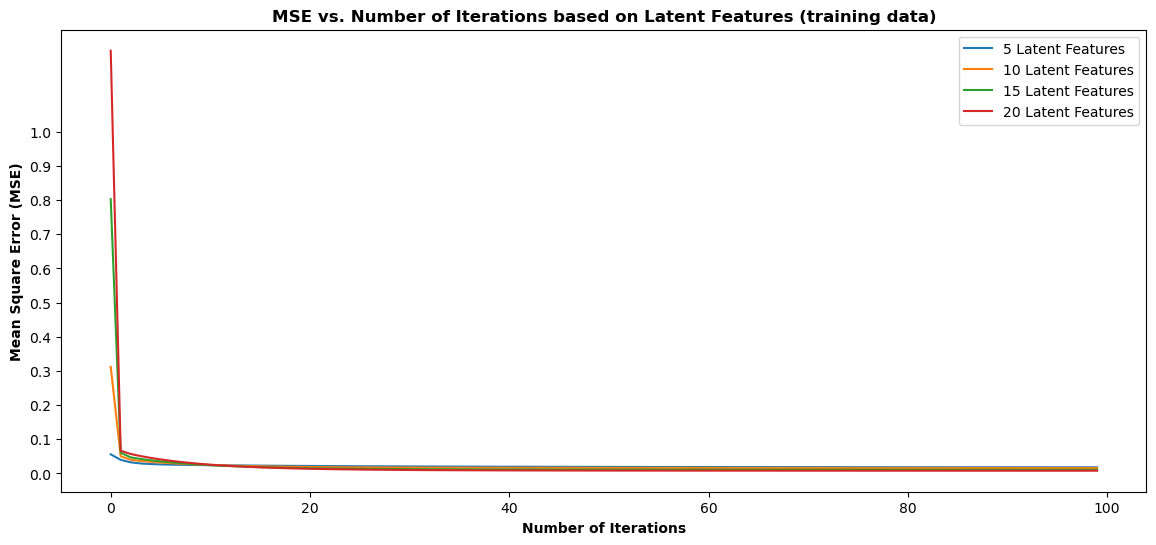

In [86]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))
plt.plot(range(iters), mse5, label = '5 Latent Features')
plt.plot(range(iters), mse10, label = '10 Latent Features')
plt.plot(range(iters), mse15, label = '15 Latent Features')
plt.plot(range(iters), mse20, label = '20 Latent Features')

plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Square Error (MSE)', weight = 'bold')
plt.title('MSE vs. Number of Iterations based on Latent Features (training data)', weight = 'bold')

plt.legend();

In [87]:
# predict reaction for customer_id / offer_id according to FunkSVD on testing data
customer_id = 13234
offer_id = 8
pred = rec.predict_offer(customer_id, offer_id)

For user 13234, we predict a 0.9115254129643648 rating for offer 8.


In [88]:
# make recommendations according to FunkSVD on testing data - valid customer
_id = 1079
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

Top offers for customer 1079 according to prediction: [10  8  4  6  5]


In [89]:
# make recommendations according to FunkSVD on testing data - invalid customer
_id = 99999
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

The top 5 offer recommendations for customer 99999:
Because this user wasn't in our database, we are giving back the top offer recommendations for all users.
Top offer recommendations: [8, 4, 1, 9, 5]


In [93]:
# make recommendations according to FunkSVD on testing data - valid offer
_id = 6
rec_type = 'offer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

KeyError: 6

In [92]:
test.offer_id.value_counts()

10    34650
9      5141
1      4934
8      4838
7      4513
4      4435
6      4155
2      3930
5      3620
0      3483
3      2935
Name: offer_id, dtype: int64